In [1]:
# Libaries to import 
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# All class definitions that will be used to simulate blackjack games

class Card: # Standard deck consists of 52 cards [13 cards per suit]
    rank_values = {
        'Ace': 11,  # Can be 1 or 11, will be handled in a method
        'Two': 2,
        'Three': 3,
        'Four': 4,
        'Five': 5,
        'Six': 6,
        'Seven': 7,
        'Eight': 8,
        'Nine': 9,
        'Ten': 10,
        'Jack': 10,
        'Queen': 10,
        'King': 10
    }
    
    def __init__(self, r, s):
        self.rank = r
        self.suit = s
        self.value = self.rank_values[r]
        
    def __str__(self):
        return f"{self.rank} of {self.suit}"



class Deck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['Ace', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten', 'Jack', 'Queen', 'King']

    def __init__(self):
        self.cards = [Card(rank, suit) for rank in self.ranks for suit in self.suits] 
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.cards) # shuffling is done with the random library

    def deal(self):
        if(len(self.cards) == 0):
            print("No cards left in the deck")
            return
        return self.cards.pop() 
        
    def decklist(self):
        for card in self.cards:
            print(card.rank, "of", card.suit)

    def __str__(self): 
        return "Deck size: " + str(len(self.cards))


        
class InfiniteDeck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['Ace', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten', 'Jack', 'Queen', 'King']

    def __init__(self):
        self.ALL_CARDS = [Card(rank, suit) for rank in self.ranks for suit in self.suits]

    def deal(self):
        return random.choice(self.ALL_CARDS) 



class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def total(self):
        total = sum(card.value for card in self.cards)
        # Handle ace logic
        aces = [card for card in self.cards if card.rank == 'Ace']
        while total > 21 and aces:
            total -= 10
            aces.pop()
        return total

    def total_p4(self): # this total method forces aces to be counted as 1 if the hand total is 14 or less. This will only be used in policy 4.
        total = sum(card.value for card in self.cards)
        # Handle ace logic
        aces = [card for card in self.cards if card.rank == 'Ace']
        while total < 15 and aces:
            total -= 10
            aces.pop()
        return total 

    def is_soft(self):
        total = sum(card.value for card in self.cards)
        for card in self.cards:
            if card.rank == 'Ace':
                if total <= 21:
                    return True
                total -= 10  # Try using ace as 1 instead of 11
        return False


    def is_blackjack(self):
        return len(self.cards) == 2 and self.total() == 21

    def is_bust(self):
        return self.total() > 21

    def show(self, hide_first=False):
        if hide_first:
            return f"Hidden | {' | '.join(str(c) for c in self.cards[1:])}"
        return ' | '.join(str(card) for card in self.cards)



class Player(Hand):
    pass



class Dealer(Hand):
    def should_hit(self):
        return self.total() < 17



class Game:
    def __init__(self, infinite=False):
        self.deck = InfiniteDeck() if infinite else Deck()
        self.player = Player()
        self.dealer = Dealer()

    def initial_deal(self):
        for _ in range(2):
            self.player.add_card(self.deck.deal())
            self.dealer.add_card(self.deck.deal())

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            print("Updated Dealer's hand:", self.dealer.show())
            if(self.dealer.is_bust()):
                print("Dealer busted. Player wins!")
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            print("Dealer wins!")
        elif self.dealer.total() < self.player.total():
            print("Player wins!")
        else:
            print("It's a tie!")
                

    def check_player_action(self):
        action = input("Enter 'h' to hit or 's' to stand.")
        if (action == 'h'):
            self.player.add_card(self.deck.deal()) # add a card
            print("Updated Player's Hand:", self.player.show()) # display new card 
            if (self.player.is_bust()):
                print("Player busted. Dealer Wins!")
            else:
                self.check_player_action()
        elif (action == 's'):
            print("Dealer's revealed hand:", self.dealer.show())
            self.check_dealer_action() 
            
    def check_game_state(self):
        if (self.player.is_blackjack() and self.dealer.is_blackjack()):
            print("Dealer's Hand Revealed:", self.dealer.show())
            print("Both dealer and player got blackjack! It's a tie!")
            
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            print("Dealer's Hand Revealed:", self.dealer.show())
            print("Dealer wins!")
            
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            print("Dealer's Hand Revealed:", self.dealer.show())
            print("Player wins!")
            
        else:
            print("Awaiting player action")
            self.check_player_action()

    def play(self):
        self.initial_deal()
        print("Dealer's Hand:", self.dealer.show(hide_first=True))
        print("Player's Hand:", self.player.show())
        self.check_game_state()

In [3]:
# Function that will be used to automate games with specified policy
def run_policy(policy_class, policy_name, infinite=False, repeats=10, games_per_run=100_000):
    results = []

    for i in range(repeats):
        game = policy_class(infinite=infinite)
        game.simulate_games(games_per_run)
        
        total_games = game.player_wins + game.dealer_wins + game.ties
        win_rate = game.player_wins / total_games
        loss_rate = game.dealer_wins / total_games
        tie_rate = game.ties / total_games
        
        results.append({
            'Policy': policy_name,
            'Deck Type': 'Infinite' if infinite else 'Finite',
            'Run': i + 1,
            'Player Wins': game.player_wins,
            'Dealer Wins': game.dealer_wins,
            'Ties': game.ties,
            'Win Rate': f"{win_rate * 100:.2f}%",
            'Loss Rate': f"{loss_rate * 100:.2f}%",
            'Tie Rate': f"{tie_rate * 100:.2f}%"
        })

    return pd.DataFrame(results)


In [4]:
# Policy 1 --> If hand is ≥ 17 stick. Else hit.
class PolicyOne(Game):
    def __init__(self, infinite=False):
        super().__init__(infinite=infinite)
        self.dealer_wins = 0
        self.player_wins = 0
        self.ties = 0

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            if(self.dealer.is_bust()):
                self.player_wins += 1
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            self.dealer_wins += 1
        elif self.dealer.total() < self.player.total():
            self.player_wins += 1
        else:
            self.ties += 1
            
    
    def check_player_action(self):
        while self.player.total() < 17:
            self.player.add_card(self.deck.deal()) # add a card
            if (self.player.is_bust()):
                self.dealer_wins += 1
                return
        # player chooses to stand and action goes to dealer
        self.check_dealer_action()

    def check_game_state(self):
        if (not(self.player.is_blackjack()) and not (self.dealer.is_blackjack())):
            # game continues since no one has blackjack
            # print("Awaiting player action") # PRINT LINE FOR TESTING 
            self.check_player_action()
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            # player has blackjack while dealer doesn't
            # print("Dealer's Hand Revealed:", self.dealer.show()) # PRINT LINE FOR TESTING
            # print("Player wins!") # PRINT LINE FOR TESTING
            self.player_wins += 1
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            # dealer has blackjack while player doesn't 
            # print("Dealer's Hand Revealed:", self.dealer.show()) # PRINT LINE FOR TESTING
            # print("Dealer wins!") # PRINT LINE FOR TESTING
            self.dealer_wins += 1
        else:
            # both dealer and player have blackjack
            # print("Dealer's Hand Revealed:", self.dealer.show()) # PRINT LINE FOR TESTING
            # print("Both dealer and player got blackjack! It's a tie!") # PRINT LINE FOR TESTING
            self.ties += 1
    
    def play_single_game(self):
        self.initial_deal()
        self.check_game_state()

    def simulate_games(self, n=100000):
        for _ in range(n):
            self.deck = Deck() # reset deck
            self.player = Player() # reset player hand
            self.dealer = Dealer() # reset dealer hand
            self.play_single_game()
        #print(f"Policy One - If hand is ≥ 17 stick. Else hit.")
        #print(f"After {n} games:")
        #print(f"Player Wins: {self.player_wins}")
        #print(f"Dealer Wins: {self.dealer_wins}")
        #print(f"Ties: {self.ties}")

In [5]:
# Policy 2 --> If hand is ≥ 17 and is hard, stick. Else hit unless hand equals 21.
class PolicyTwo(Game): 
    def __init__(self, infinite=False):
        super().__init__(infinite=infinite)
        self.dealer_wins = 0
        self.player_wins = 0
        self.ties = 0

    def check_game_state(self):
        if (not(self.player.is_blackjack()) and not (self.dealer.is_blackjack())):
            # game continues since no one has blackjack
            self.check_player_action()
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            # player has blackjack while dealer doesn't
            self.player_wins += 1
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            # dealer has blackjack while player doesn't 
            self.dealer_wins += 1
        else:
            # both dealer and player have blackjack
            self.ties += 1

    def check_player_action(self):
        while self.player.is_soft():
            if self.player.total() == 21:
                break
            else:
                self.player.add_card(self.deck.deal()) # add a card
        while self.player.total() < 17:
            self.player.add_card(self.deck.deal()) # add a card
            if (self.player.is_bust()):
                self.dealer_wins += 1
                return
        # player chooses to stand and action goes to dealer
        self.check_dealer_action()

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            if(self.dealer.is_bust()):
                self.player_wins += 1
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            self.dealer_wins += 1
        elif self.dealer.total() < self.player.total():
            self.player_wins += 1
        else:
            self.ties += 1

    def play_single_game(self):
        self.initial_deal()
        self.check_game_state()

    def simulate_games(self, n=100000):
        for _ in range(n):
            self.deck = Deck() # reset deck
            self.player = Player() # reset player hand
            self.dealer = Dealer() # reset dealer hand
            self.play_single_game()
        #print(f"Policy Two - If hand is ≥ 17 and is hard, stick. Else hit unless hand equals 21.")
        #print(f"After {n} games:")
        #print(f"Player Wins: {self.player_wins}")
        #print(f"Dealer Wins: {self.dealer_wins}")
        #print(f"Ties: {self.ties}")

In [6]:
# Policy 3 --> Always stick.
class PolicyThree(Game):
    def __init__(self, infinite=False):
        super().__init__(infinite=infinite)
        self.dealer_wins = 0
        self.player_wins = 0
        self.ties = 0

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            if(self.dealer.is_bust()):
                self.player_wins += 1
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            self.dealer_wins += 1
        elif self.dealer.total() < self.player.total():
            self.player_wins += 1
        else:
            self.ties += 1

    def check_player_action(self):
        # player chooses to stand and action goes to dealer
        self.check_dealer_action()

    def check_game_state(self):
        if (not(self.player.is_blackjack()) and not (self.dealer.is_blackjack())):
            # game continues since no one has blackjack
            self.check_player_action()
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            # player has blackjack while dealer doesn't
            self.player_wins += 1
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            # dealer has blackjack while player doesn't 
            self.dealer_wins += 1
        else:
            # both dealer and player have blackjack
            self.ties += 1

    def play_single_game(self):
        self.initial_deal()
        self.check_game_state()

    def simulate_games(self, n=100000):
        for _ in range(n):
            self.deck = Deck() # reset deck
            self.player = Player() # reset player hand
            self.dealer = Dealer() # reset dealer hand
            self.play_single_game()
        #print(f"Policy Three - Always stick.")
        #print(f"After {n} games:")
        #print(f"Player Wins: {self.player_wins}")
        #print(f"Dealer Wins: {self.dealer_wins}")
        #print(f"Ties: {self.ties}")    

In [7]:
# Policy 4 --> If soft hand is ≤ 14, hit. If hard hand is ≤ 11, hit. Else stand.
class PolicyFour(Game): 
    def __init__(self, infinite=False):
        super().__init__(infinite=infinite)
        self.dealer_wins = 0
        self.player_wins = 0
        self.ties = 0

    def check_game_state(self):
        if (not(self.player.is_blackjack()) and not (self.dealer.is_blackjack())):
            # game continues since no one has blackjack
            self.check_player_action()
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            # player has blackjack while dealer doesn't
            self.player_wins += 1
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            # dealer has blackjack while player doesn't 
            self.dealer_wins += 1
        else:
            # both dealer and player have blackjack
            self.ties += 1

    def check_player_action(self):
        if self.player.is_soft():
            while self.player.total_p4() < 15: # If hand contains Aces, they should be counted as 1 unless the total value of the hand is 15 or greater 
                self.player.add_card(self.deck.deal()) # add a card
        else:
            while self.player.total() <= 11:
                self.player.add_card(self.deck.deal())
        # player chooses to stand and action goes to dealer
        self.check_dealer_action()

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            if(self.dealer.is_bust()):
                self.player_wins += 1
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            self.dealer_wins += 1
        elif self.dealer.total() < self.player.total():
            self.player_wins += 1
        else:
            self.ties += 1

    def play_single_game(self):
        self.initial_deal()
        self.check_game_state()

    def simulate_games(self, n=100000):
        for _ in range(n):
            self.deck = Deck() # reset deck
            self.player = Player() # reset player hand
            self.dealer = Dealer() # reset dealer hand
            self.play_single_game()
        #print(f"Policy Four - If soft hand is ≤ 14, hit. If hard hand is ≤ 11, hit. Else stand.")
        #print(f"After {n} games:")
        #print(f"Player Wins: {self.player_wins}")
        #print(f"Dealer Wins: {self.dealer_wins}")
        #print(f"Ties: {self.ties}")    

In [8]:
# Policy 5 --> Implement basic strategy (modified).
class PolicyFive(Game):
    def __init__(self, infinite=False):
        super().__init__(infinite=infinite)
        self.dealer_wins = 0
        self.player_wins = 0
        self.ties = 0

    def check_game_state(self):
        if (not(self.player.is_blackjack()) and not (self.dealer.is_blackjack())):
            # game continues since no one has blackjack
            self.check_player_action()
        elif (self.player.is_blackjack() and not (self.dealer.is_blackjack())):
            # player has blackjack while dealer doesn't
            self.player_wins += 1
        elif (not(self.player.is_blackjack()) and self.dealer.is_blackjack()):
            # dealer has blackjack while player doesn't 
            self.dealer_wins += 1
        else:
            # both dealer and player have blackjack
            self.ties += 1

    def check_player_action(self):
        # implement basic strategy here
        if self.player.is_soft():
            # basic strategy using soft hand totals
            if self.player.total() <= 17:
                #player chooses to hit
                self.player.add_card(self.deck.deal()) # add a card
                self.check_player_action() # No need to check for bust since not possible to bust with a soft hand
            elif self.player.total() == 18:
                if self.dealer.cards[1].value < 9:
                    # player chooses to stand
                    self.check_dealer_action()
                else:
                    #player chooses to hit
                    self.player.add_card(self.deck.deal()) # add a card
                    self.check_player_action() # No need to check for bust since not possible to bust with a soft hand
            else: # If hand is 19+
                #player chooses to stand
                self.check_dealer_action()
        else:
            # basic strategy using hard hand totals
            if self.player.total() <= 11:
                self.player.add_card(self.deck.deal()) # add a card
                self.check_player_action() # don't need to check for bust because impossible to bust when hitting on 11 or less
            elif self.player.total() == 12:
                if self.dealer.cards[1].value >= 4 and self.dealer.cards[1].value <= 6:
                    # player chooses to stand
                    self.check_dealer_action()
                else:
                    #player chooses to hit
                    self.player.add_card(self.deck.deal()) # add a card
                    if (self.player.is_bust()):
                        self.dealer_wins += 1
                        return
                    self.check_player_action()
            elif self.player.total() < 17:
                if self.dealer.cards[1].value > 6:
                    self.player.add_card(self.deck.deal()) # add a card
                    if (self.player.is_bust()):
                        self.dealer_wins += 1
                        return
                    self.check_player_action()
                else:
                    #player chooses to stand
                    self.check_dealer_action()
            else: # if hand is >= 17, stand!
                self.check_dealer_action()

    def check_dealer_action(self):
        while self.dealer.should_hit():
            self.dealer.add_card(self.deck.deal())
            if(self.dealer.is_bust()):
                self.player_wins += 1
                return
        # Dealer stands
        # compare dealer total to player total to determine who wins
        if self.dealer.total() > self.player.total():
            self.dealer_wins += 1
        elif self.dealer.total() < self.player.total():
            self.player_wins += 1
        else:
            self.ties += 1

    def play_single_game(self):
        self.initial_deal()
        self.check_game_state()

    def simulate_games(self, n=100000):
        for _ in range(n):
            self.deck = Deck() # reset deck
            self.player = Player() # reset player hand
            self.dealer = Dealer() # reset dealer hand
            self.play_single_game()
        #print(f"Policy Five - Implement basic strategy (modified).")
        #print(f"After {n} games:")
        #print(f"Player Wins: {self.player_wins}")
        #print(f"Dealer Wins: {self.dealer_wins}")
        #print(f"Ties: {self.ties}")   

In [9]:
# Play blackjack with user input 
blackjack = Game()
blackjack.play()

Dealer's Hand: Hidden | Queen of Spades
Player's Hand: Eight of Hearts | Jack of Hearts
Awaiting player action


Enter 'h' to hit or 's' to stand. s


Dealer's revealed hand: Five of Hearts | Queen of Spades
Updated Dealer's hand: Five of Hearts | Queen of Spades | Seven of Spades
Dealer busted. Player wins!


In [10]:
# Running 10 trials for policy 1 with finite deck (each trial is 100,000 games)
# Function returns a dataframe
policy1_finite = run_policy(PolicyOne, "Policy One", infinite=False)

In [11]:
# Running 10 trials for policy 1 with infinite deck (each trial is 100,000 games)
# Function returns a dataframe
policy1_infinite = run_policy(PolicyOne, "Policy One", infinite=True)

In [12]:
# Running 10 trials for policy 2 with finite deck (each trial is 100,000 games)
# Function returns a dataframe
policy2_finite = run_policy(PolicyTwo, "Policy Two", infinite=False)

In [13]:
# Running 10 trials for policy 2 with infinite deck (each trial is 100,000 games)
# Function returns a dataframe
policy2_infinite = run_policy(PolicyTwo, "Policy Two", infinite=True)

In [14]:
# Running 10 trials for policy 3 with finite deck (each trial is 100,000 games)
# Function returns a dataframe
policy3_finite = run_policy(PolicyThree, "Policy Three", infinite=False)

In [15]:
# Running 10 trials for policy 3 with infinite deck (each trial is 100,000 games)
# Function returns a dataframe
policy3_infinite = run_policy(PolicyThree, "Policy Three", infinite=True)

In [17]:
# Running 10 trials for policy 4 with finite deck (each trial is 100,000 games)
# Function returns a dataframe
policy4_finite = run_policy(PolicyFour, "Policy Four", infinite=False)

In [18]:
# Running 10 trials for policy 4 with infinite deck (each trial is 100,000 games)
# Function returns a dataframe
policy4_infinite = run_policy(PolicyFour, "Policy Four", infinite=True)

In [19]:
# Running 10 trials for policy 5 with finite deck (each trial is 100,000 games)
# Function returns a dataframe
policy5_finite = run_policy(PolicyFive, "Policy Five", infinite=False)

In [20]:
# Running 10 trials for policy 5 with infinite deck (each trial is 100,000 games)
# Function returns a dataframe
policy5_infinite = run_policy(PolicyFive, "Policy Five", infinite=True)

In [21]:
# Combining finite & infinite dataframes for policy 1
policy1_combined = pd.concat([policy1_finite, policy1_infinite], ignore_index=True)

In [22]:
# Combining finite & infinite dataframes for policy 2
policy2_combined = pd.concat([policy2_finite, policy2_infinite], ignore_index=True)

In [23]:
# Combining finite & infinite dataframes for policy 3
policy3_combined = pd.concat([policy3_finite, policy3_infinite], ignore_index=True)

In [24]:
# Combining finite & infinite dataframes for policy 4
policy4_combined = pd.concat([policy4_finite, policy4_infinite], ignore_index=True)

In [25]:
# Combining finite & infinite dataframes for policy 5
policy5_combined = pd.concat([policy5_finite, policy5_infinite], ignore_index=True)

In [26]:
print(policy1_combined)

        Policy Deck Type  Run  Player Wins  Dealer Wins  Ties Win Rate  \
0   Policy One    Finite    1        41424        49111  9465   41.42%   
1   Policy One    Finite    2        41502        49041  9457   41.50%   
2   Policy One    Finite    3        41410        49120  9470   41.41%   
3   Policy One    Finite    4        41366        49243  9391   41.37%   
4   Policy One    Finite    5        41253        49267  9480   41.25%   
5   Policy One    Finite    6        41284        49146  9570   41.28%   
6   Policy One    Finite    7        41113        49222  9665   41.11%   
7   Policy One    Finite    8        41437        49010  9553   41.44%   
8   Policy One    Finite    9        41402        49212  9386   41.40%   
9   Policy One    Finite   10        41335        49047  9618   41.34%   
10  Policy One  Infinite    1        41224        49476  9300   41.22%   
11  Policy One  Infinite    2        41049        49304  9647   41.05%   
12  Policy One  Infinite    3        4

In [27]:
print(policy2_combined)

        Policy Deck Type  Run  Player Wins  Dealer Wins  Ties Win Rate  \
0   Policy Two    Finite    1        40787        50052  9161   40.79%   
1   Policy Two    Finite    2        40570        50244  9186   40.57%   
2   Policy Two    Finite    3        40620        50295  9085   40.62%   
3   Policy Two    Finite    4        40744        50222  9034   40.74%   
4   Policy Two    Finite    5        40804        50127  9069   40.80%   
5   Policy Two    Finite    6        40959        49659  9382   40.96%   
6   Policy Two    Finite    7        40403        50259  9338   40.40%   
7   Policy Two    Finite    8        40528        50412  9060   40.53%   
8   Policy Two    Finite    9        40759        50118  9123   40.76%   
9   Policy Two    Finite   10        40698        50036  9266   40.70%   
10  Policy Two  Infinite    1        40866        49921  9213   40.87%   
11  Policy Two  Infinite    2        40732        50151  9117   40.73%   
12  Policy Two  Infinite    3        4

In [28]:
print(policy3_combined)

          Policy Deck Type  Run  Player Wins  Dealer Wins  Ties Win Rate  \
0   Policy Three    Finite    1        38629        56883  4488   38.63%   
1   Policy Three    Finite    2        38805        56696  4499   38.80%   
2   Policy Three    Finite    3        38941        56545  4514   38.94%   
3   Policy Three    Finite    4        38747        56633  4620   38.75%   
4   Policy Three    Finite    5        38806        56524  4670   38.81%   
5   Policy Three    Finite    6        38733        56685  4582   38.73%   
6   Policy Three    Finite    7        39084        56322  4594   39.08%   
7   Policy Three    Finite    8        38766        56605  4629   38.77%   
8   Policy Three    Finite    9        38627        56809  4564   38.63%   
9   Policy Three    Finite   10        38700        56705  4595   38.70%   
10  Policy Three  Infinite    1        38798        56615  4587   38.80%   
11  Policy Three  Infinite    2        38590        56885  4525   38.59%   
12  Policy T

In [29]:
print(policy4_combined)

         Policy Deck Type  Run  Player Wins  Dealer Wins  Ties Win Rate  \
0   Policy Four    Finite    1        42300        51447  6253   42.30%   
1   Policy Four    Finite    2        42213        51542  6245   42.21%   
2   Policy Four    Finite    3        42374        51401  6225   42.37%   
3   Policy Four    Finite    4        42318        51511  6171   42.32%   
4   Policy Four    Finite    5        42112        51728  6160   42.11%   
5   Policy Four    Finite    6        42449        51304  6247   42.45%   
6   Policy Four    Finite    7        42130        51634  6236   42.13%   
7   Policy Four    Finite    8        42214        51473  6313   42.21%   
8   Policy Four    Finite    9        42201        51619  6180   42.20%   
9   Policy Four    Finite   10        42490        51212  6298   42.49%   
10  Policy Four  Infinite    1        42158        51485  6357   42.16%   
11  Policy Four  Infinite    2        42258        51596  6146   42.26%   
12  Policy Four  Infinite

In [30]:
print(policy5_combined)

         Policy Deck Type  Run  Player Wins  Dealer Wins  Ties Win Rate  \
0   Policy Five    Finite    1        43339        48101  8560   43.34%   
1   Policy Five    Finite    2        43725        47688  8587   43.73%   
2   Policy Five    Finite    3        43501        47999  8500   43.50%   
3   Policy Five    Finite    4        43979        47679  8342   43.98%   
4   Policy Five    Finite    5        43593        47870  8537   43.59%   
5   Policy Five    Finite    6        43543        47955  8502   43.54%   
6   Policy Five    Finite    7        43519        48049  8432   43.52%   
7   Policy Five    Finite    8        43566        48077  8357   43.57%   
8   Policy Five    Finite    9        43829        47726  8445   43.83%   
9   Policy Five    Finite   10        43630        47814  8556   43.63%   
10  Policy Five  Infinite    1        43813        47668  8519   43.81%   
11  Policy Five  Infinite    2        43446        47875  8679   43.45%   
12  Policy Five  Infinite

In [31]:
# converting percetanges to floats to print averages
policy1_combined['Win Rate'] = policy1_combined['Win Rate'].str.rstrip('%').astype(float)
policy1_combined['Loss Rate'] = policy1_combined['Loss Rate'].str.rstrip('%').astype(float)
policy1_combined['Tie Rate'] = policy1_combined['Tie Rate'].str.rstrip('%').astype(float)

In [32]:
# converting percetanges to floats to print averages
policy2_combined['Win Rate'] = policy2_combined['Win Rate'].str.rstrip('%').astype(float)
policy2_combined['Loss Rate'] = policy2_combined['Loss Rate'].str.rstrip('%').astype(float)
policy2_combined['Tie Rate'] = policy2_combined['Tie Rate'].str.rstrip('%').astype(float)

In [33]:
# converting percetanges to floats to print averages
policy3_combined['Win Rate'] = policy3_combined['Win Rate'].str.rstrip('%').astype(float)
policy3_combined['Loss Rate'] = policy3_combined['Loss Rate'].str.rstrip('%').astype(float)
policy3_combined['Tie Rate'] = policy3_combined['Tie Rate'].str.rstrip('%').astype(float)

In [34]:
# converting percetanges to floats to print averages
policy4_combined['Win Rate'] = policy4_combined['Win Rate'].str.rstrip('%').astype(float)
policy4_combined['Loss Rate'] = policy4_combined['Loss Rate'].str.rstrip('%').astype(float)
policy4_combined['Tie Rate'] = policy4_combined['Tie Rate'].str.rstrip('%').astype(float)

In [35]:
# converting percetanges to floats to print averages
policy5_combined['Win Rate'] = policy5_combined['Win Rate'].str.rstrip('%').astype(float)
policy5_combined['Loss Rate'] = policy5_combined['Loss Rate'].str.rstrip('%').astype(float)
policy5_combined['Tie Rate'] = policy5_combined['Tie Rate'].str.rstrip('%').astype(float)

In [36]:
policy1_averages = policy1_combined.groupby("Deck Type")[["Win Rate", "Loss Rate", "Tie Rate"]].mean()
print(policy1_averages.round(2))

           Win Rate  Loss Rate  Tie Rate
Deck Type                               
Finite        41.35      49.14      9.51
Infinite      41.27      49.29      9.44


In [37]:
policy2_averages = policy2_combined.groupby("Deck Type")[["Win Rate", "Loss Rate", "Tie Rate"]].mean()
print(policy2_averages.round(2))

           Win Rate  Loss Rate  Tie Rate
Deck Type                               
Finite        40.69      50.14      9.17
Infinite      40.62      50.20      9.18


In [38]:
policy3_averages = policy3_combined.groupby("Deck Type")[["Win Rate", "Loss Rate", "Tie Rate"]].mean()
print(policy3_averages.round(2))

           Win Rate  Loss Rate  Tie Rate
Deck Type                               
Finite        38.78      56.64      4.57
Infinite      38.69      56.74      4.57


In [39]:
policy4_averages = policy4_combined.groupby("Deck Type")[["Win Rate", "Loss Rate", "Tie Rate"]].mean()
print(policy4_averages.round(2))

           Win Rate  Loss Rate  Tie Rate
Deck Type                               
Finite        42.28      51.49      6.23
Infinite      42.26      51.54      6.20


In [40]:
policy5_averages = policy5_combined.groupby("Deck Type")[["Win Rate", "Loss Rate", "Tie Rate"]].mean()
print(policy5_averages.round(2))

           Win Rate  Loss Rate  Tie Rate
Deck Type                               
Finite        43.62      47.90      8.48
Infinite      43.54      47.91      8.55


In [41]:
all_policies_combined = pd.concat([policy1_combined, policy2_combined, policy3_combined, policy4_combined, policy5_combined], ignore_index=True)

In [42]:
sns.set_theme(style="whitegrid")

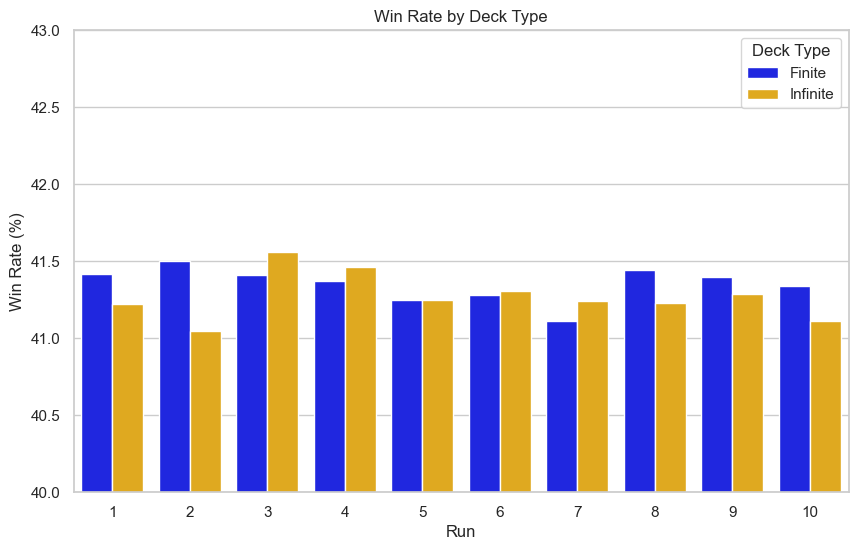

In [47]:
# barplot showing results for policy 1 (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=policy1_combined, x='Run', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(40, 43)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("policy1_combined_winrate.png")
plt.show()

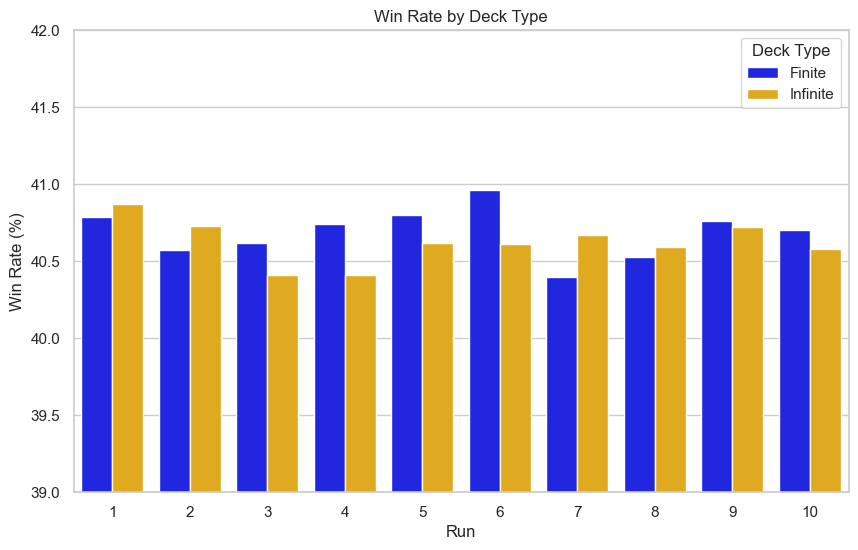

In [48]:
# barplot showing results for policy 2 (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=policy2_combined, x='Run', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(39, 42)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("policy2_combined_winrate.png")
plt.show()

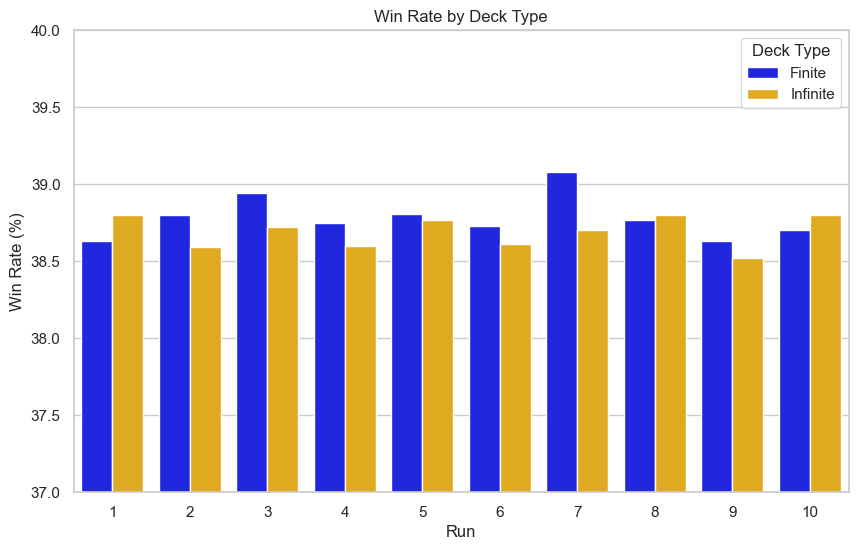

In [49]:
# barplot showing results for policy 3 (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=policy3_combined, x='Run', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(37, 40)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("policy3_combined_winrate.png")
plt.show()

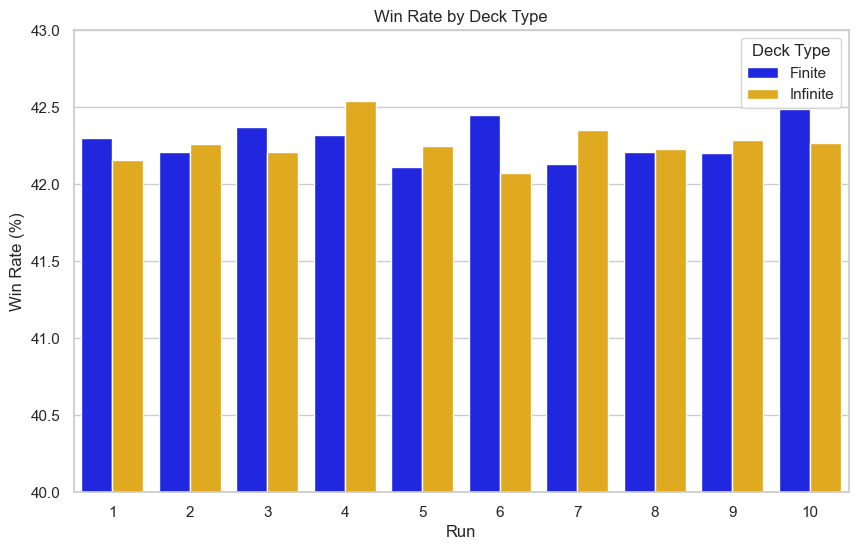

In [50]:
# barplot showing results for policy 4 (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=policy4_combined, x='Run', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(40, 43)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("policy4_combined_winrate.png")
plt.show()

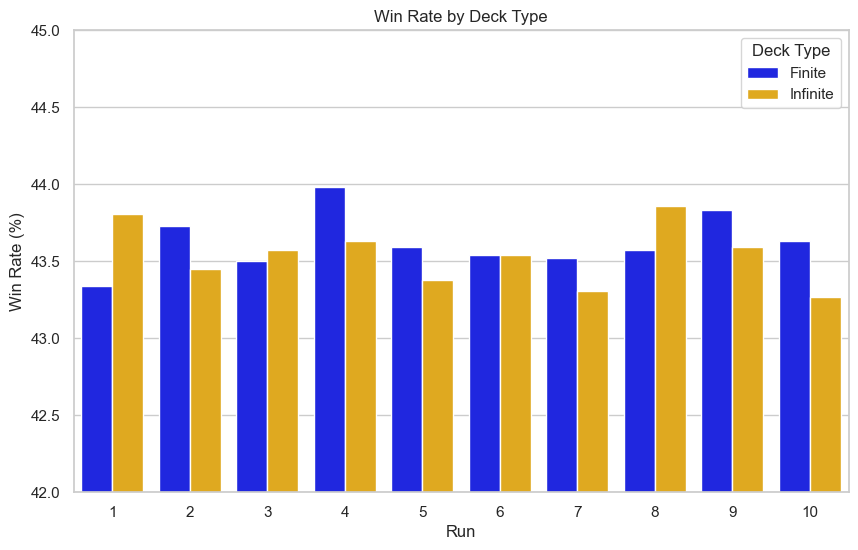

In [51]:
# barplot showing results for policy 5 (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=policy5_combined, x='Run', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(42, 45)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("policy5_combined_winrate.png")
plt.show()

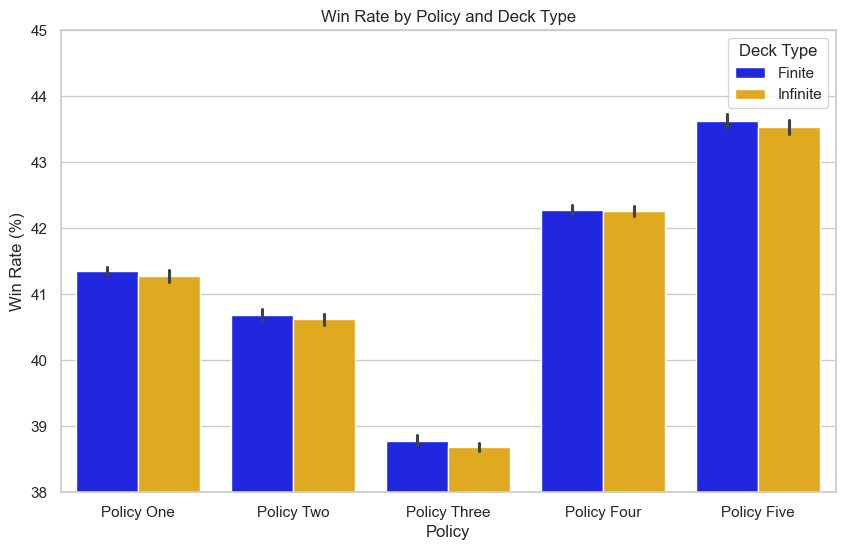

In [52]:
# barplot showing results for all policies (both finite and infinite decks)
plt.figure(figsize=(10, 6))
sns.barplot(data=all_policies_combined, x='Policy', y='Win Rate', hue='Deck Type', palette={'Finite': '#000aff', 'Infinite': '#ffb700'})
plt.title("Win Rate by Policy and Deck Type")
plt.ylabel("Win Rate (%)")
plt.ylim(38, 45)

#UNCOMMENT LINE BELOW TO SAVE FIGURE AS PNG
#plt.savefig("all_policies_combined_winrate.png")
plt.show()

In [ ]:
#UNCOMMENT LINES BELOW TO SAVE RESULTS AS .CSV

#policy1_combined.to_csv("policy1_results.csv", index=False)
#policy2_combined.to_csv("policy2_results.csv", index=False)
#policy3_combined.to_csv("policy3_results.csv", index=False)
#policy4_combined.to_csv("policy4_results.csv", index=False)
#policy5_combined.to_csv("policy5_results.csv", index=False)